In [2]:
from mlflow.tracking import MlflowClient
import tempfile
import pandas as pd
import mlflow

#for module import
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from shared_functions.gg_sheet import *

In [ ]:
!mlflow ui

In [3]:
experiment_name = "Legal_doc_Experiment"
mlflow.set_experiment(experiment_name)

# Get experiment info
experiment = mlflow.get_experiment_by_name(experiment_name)
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Experiment Name: {experiment.name}")
print(f"Artifact Location: {experiment.artifact_location}")

2025/10/01 14:28:50 INFO mlflow.tracking.fluent: Experiment with name 'Legal_doc_Experiment' does not exist. Creating a new experiment.


Experiment ID: 988753582389223624
Experiment Name: Legal_doc_Experiment
Artifact Location: file:///d:/Study/Education/Projects/Group_Project/rag_model/mlruns/988753582389223624


In [4]:
mlflow_client = MlflowClient()

# Search for runs within the experiment
# You can add filters and order_by clauses to refine your search.

runs = mlflow_client.search_runs(
    experiment_ids=[experiment.experiment_id],
    # filter_string="status = 'FINISHED'", # Example filter
    order_by=['start_time DESC'],  # Order by start time, most recent first
    max_results=100,  # Limit the number of runs to fetch
)

#### What the UI looks like 

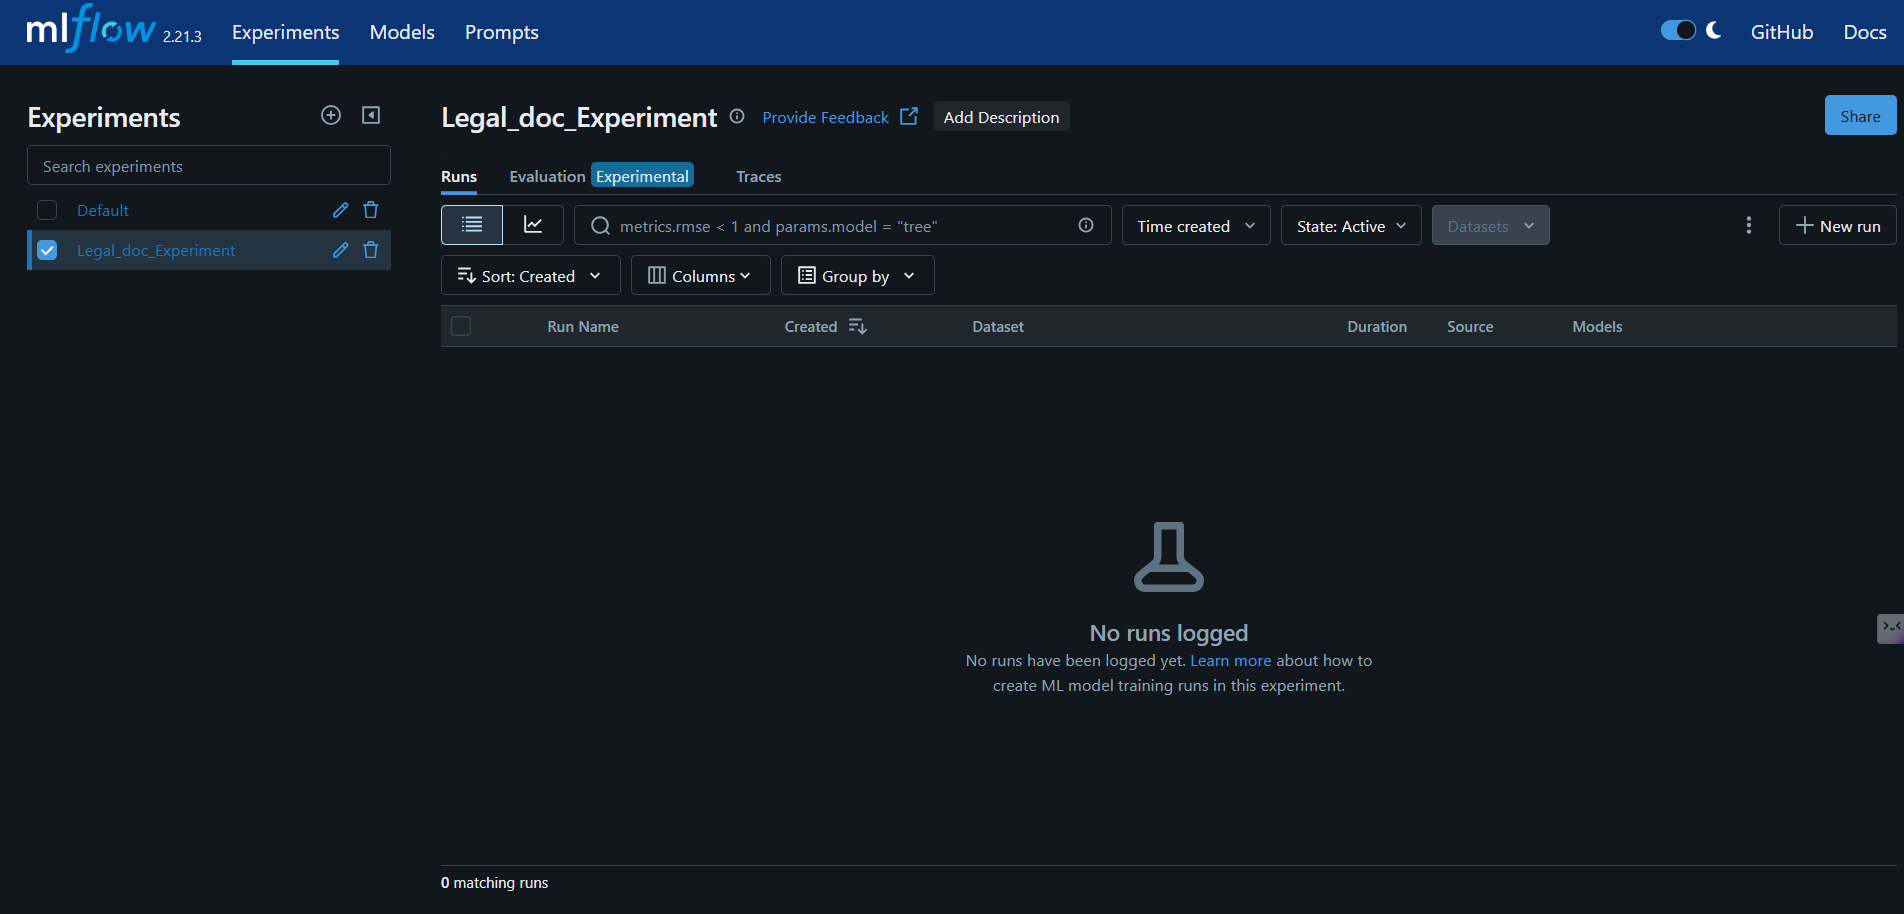

In [ ]:
#List of runs on the mlflow UI

runs

[]

In [6]:
for run in runs:
    run_id = run.info.run_id
    run_name = run.info.run_name

    # list files logged at the root of the run
    artifacts = mlflow_client.list_artifacts(run_id)
    should_skip = False
    for artifact in artifacts:
        if artifact.is_dir == False and artifact.path == 'ragas_evaluation.json':
            should_skip = True

    if should_skip:
        print(f'already have table, skip, {run_id=}')
        continue

    for artifact in artifacts:
        files_artifacts = mlflow_client.list_artifacts(run.info.run_id, artifact.path)
        for file_artifact in files_artifacts:
            if file_artifact.path.endswith('.parquet'):
                with tempfile.TemporaryDirectory() as temp_dir:
                    local_path = mlflow_client.download_artifacts(run_id, file_artifact.path, temp_dir)
                    print(f'Reading artifact from {local_path=}')
                    df_art = pd.read_parquet(local_path)
                    with mlflow.start_run(run_id=run_id):
                        mlflow.log_table(df_art, 'ragas_evaluation.json')
                        print(f'Logged table for run: {run_name} ({run_id})  →  {file_artifact.path}')

In [7]:
def extract_df(run_id): 
  run = runs[run_id]
  run_id = run.info.run_id
  run_name = run.info.run_name

  # list files logged at the root of the run
  artifacts = mlflow_client.list_artifacts(run_id)
  should_skip = False
  for artifact in artifacts:
      if artifact.is_dir == False and artifact.path == 'ragas_evaluation.json':
          should_skip = True

  for artifact in artifacts:
      files_artifacts = mlflow_client.list_artifacts(run.info.run_id, artifact.path)
      for file_artifact in files_artifacts:
          if file_artifact.path.endswith('.parquet'):
              with tempfile.TemporaryDirectory() as temp_dir:
                  local_path = mlflow_client.download_artifacts(run_id, file_artifact.path, temp_dir)
                  print(f'Reading artifact from {local_path=}')
                  df_art = pd.read_parquet(local_path)
  return df_art

In [ ]:
### Parse the run information as table format stored in pd.DataFrame

trace = extract_df(0) #the first run (latest one)

In [ ]:
## Load the dataframe on spreadsheet for better visualization
# The spreadsheet link is: https://docs.google.com/spreadsheets/d/1xBgBiA1KwTNdqPfrqH5p_Sf-MhTCXMfy4ousb0WE4Ik/edit?gid=0#gid=0

write_df_to_gs(trace, tab_name='test')